In [2]:
# Install Library
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.1 MB/s eta 0:00:00


In [3]:
!pip install -U langchain langchain-community langchain-experimental replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 3.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [5]:
# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
from google.colab import userdata
import os

# get api_token from colab
api_token = userdata.get('api_token')

os.environ['REPLICATE_API_TOKEN'] = api_token

In [7]:
from langchain_community.llms import Replicate

llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct"
)

In [8]:
# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/IMB Granite Data Classification & Summirzation/rows.csv")

df.head()

/tmp/ipython-input-2358848061.py:2: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/IMB Granite Data Classification & Summirzation/rows.csv")


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228
2,05/10/2019,Debt collection,Payday loan debt,Communication tactics,Frequent or repeated calls,NaN,NaN,CURO Intermediate Holdings,TX,751XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3237964
3,05/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,NaN,NaN,Ad Astra Recovery Services Inc,LA,708XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3238479
4,05/10/2019,Checking or savings account,Checking account,Managing an account,Banking errors,NaN,NaN,ALLY FINANCIAL INC.,AZ,85205,NaN,NaN,Postal mail,05/10/2019,In progress,Yes,NaN,3238460


In [9]:
df.shape #awal (1282355, 18)

(1282355, 18)

### Data Cleaning

In [10]:
# cek data duplikat
df.duplicated().sum()

np.int64(0)

In [11]:
# Cek missing values
df.isnull().sum()

,0
Date received,0
Product,0
Sub-product,235166
Issue,0
Sub-issue,531186
Consumer complaint narrative,898791
Company public response,833273
Company,0
State,19400
ZIP code,115298


In [12]:
# Penanganan Kolom dengan missing values kecil
# null value pada kolom state, zip code, dan company response to cunsumer diisi dengan 'unkwnon'
df['State'] = df['State'].fillna('Unknown')
df['ZIP code'] = df['ZIP code'].fillna('Unknown')
df['Company response to consumer'] = df['Company response to consumer'].fillna('Unknown')
df['Consumer consent provided?'] = df['Consumer consent provided?'].fillna('Unknown')
df['Consumer disputed?'] = df['Consumer disputed?'].fillna('Unknown')
df['Sub-product'] = df['Sub-product'].fillna('Unknown')

In [13]:
# cek kolom dengan missing value lebih dari 50%
missing_percentage = (df.isnull().sum() / len(df)) * 100
kolom_banyak_missing = missing_percentage[missing_percentage > 50]
print("Kolom dengan missing value > 50%:")
print(kolom_banyak_missing)

Kolom dengan missing value > 50%:
Consumer complaint narrative    70.089094
Company public response         64.979900
Tags                            86.303091
dtype: float64


In [14]:
df.drop(columns=['Consumer complaint narrative', 'Company public response', 'Tags', 'Sub-issue'], axis=1, inplace=True)

In [15]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Company', 'State',
       'ZIP code', 'Consumer consent provided?', 'Submitted via',
       'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282355 entries, 0 to 1282354
Data columns (total 14 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Date received                 1282355 non-null  object
 1   Product                       1282355 non-null  object
 2   Sub-product                   1282355 non-null  object
 3   Issue                         1282355 non-null  object
 4   Company                       1282355 non-null  object
 5   State                         1282355 non-null  object
 6   ZIP code                      1282355 non-null  object
 7   Consumer consent provided?    1282355 non-null  object
 8   Submitted via                 1282355 non-null  object
 9   Date sent to company          1282355 non-null  object
 10  Company response to consumer  1282355 non-null  object
 11  Timely response?              1282355 non-null  object
 12  Consumer disputed?            1282355 non-

In [17]:
#Normalisasi kolom teks
import re
import string
import pandas as pd

def normalize_text(text):
    if pd.isnull(text):
        return "unknown"
    text = str(text).lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text.strip()

text_columns = ['Product', 'Sub-product', 'Issue', 'Company', 'State',
       'ZIP code', 'Consumer consent provided?', 'Submitted via',
       'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?']

for col in text_columns:
    if col in df.columns:
        df[col] = df[col].apply(normalize_text)


### Exploratory Data Analysis (EDA)

In [18]:
# cek data awal
print(df.shape)
print(df.info())
print(df.isnull().sum())
df.head()

(1282355, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282355 entries, 0 to 1282354
Data columns (total 14 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Date received                 1282355 non-null  object
 1   Product                       1282355 non-null  object
 2   Sub-product                   1282355 non-null  object
 3   Issue                         1282355 non-null  object
 4   Company                       1282355 non-null  object
 5   State                         1282355 non-null  object
 6   ZIP code                      1282355 non-null  object
 7   Consumer consent provided?    1282355 non-null  object
 8   Submitted via                 1282355 non-null  object
 9   Date sent to company          1282355 non-null  object
 10  Company response to consumer  1282355 non-null  object
 11  Timely response?              1282355 non-null  object
 12  Consumer disputed?          

,Date received,Product,Sub-product,Issue,Company,State,ZIP code,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,checking savings account,checking account,managing account,navy federal credit union,fl,xx,unknown,web,,progress,yes,unknown,3238275
1,05/10/2019,checking savings account,banking product service,managing account,boeing employees credit union,wa,,unknown,referral,,closed explanation,yes,unknown,3238228
2,05/10/2019,debt collection,payday loan debt,communication tactics,curo intermediate holdings,tx,xx,unknown,web,,closed explanation,yes,unknown,3237964
3,05/10/2019,credit reporting credit repair services person...,credit reporting,incorrect information report,ad astra recovery services inc,la,xx,unknown,web,,closed explanation,yes,unknown,3238479
4,05/10/2019,checking savings account,checking account,managing account,ally financial inc,az,,unknown,postal mail,,progress,yes,unknown,3238460


#### Analisis Data Kategorikal

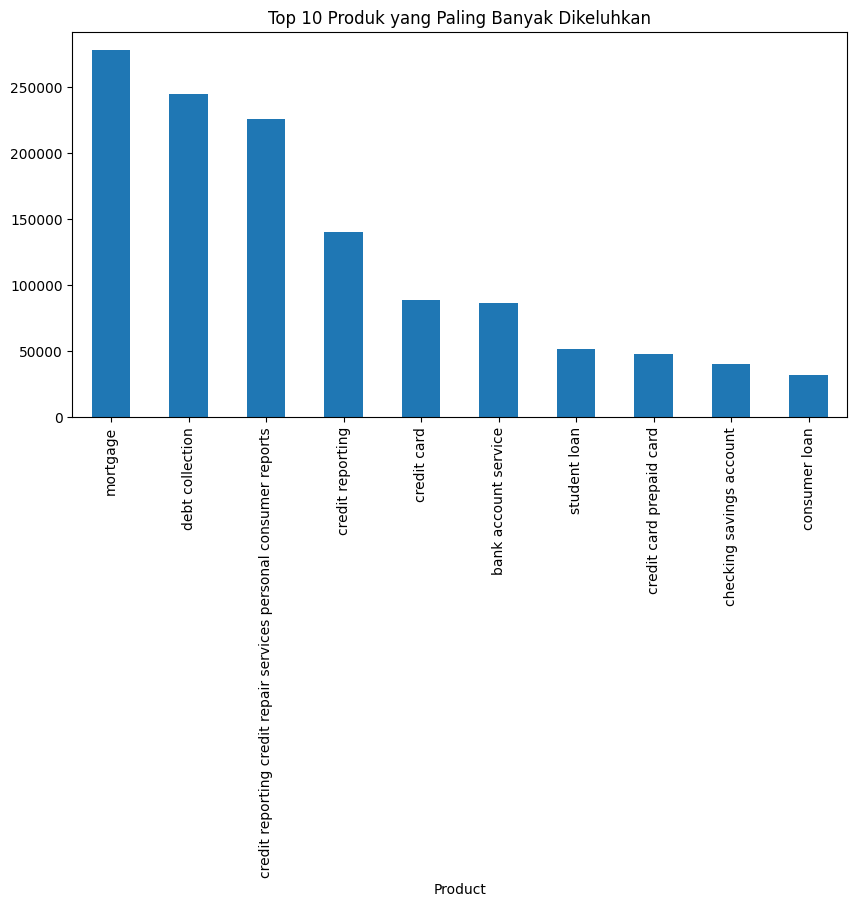

In [19]:
# Distribusi Produk
#df['Product'].value_counts().head(10)
df['Product'].value_counts().head(10).plot(kind='bar', figsize=(10,5), title="Top 10 Produk yang Paling Banyak Dikeluhkan")
plt.show()

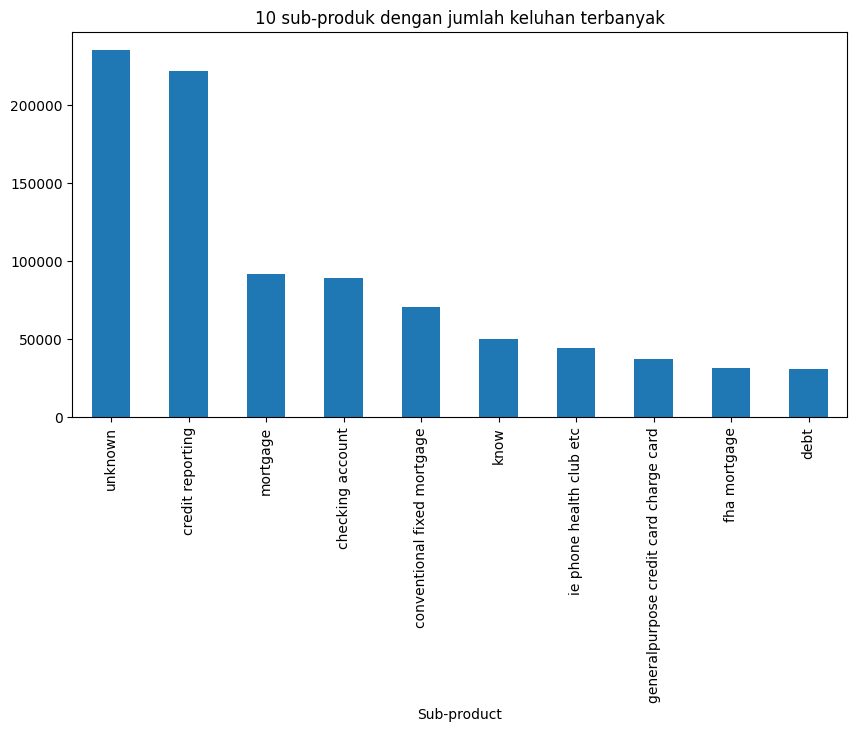

In [20]:
# Sub-product
#df['Sub-product'].value_counts().head(10)
df['Sub-product'].value_counts().head(10).plot(kind='bar', figsize=(10,5), title="10 sub-produk dengan jumlah keluhan terbanyak")
plt.show()

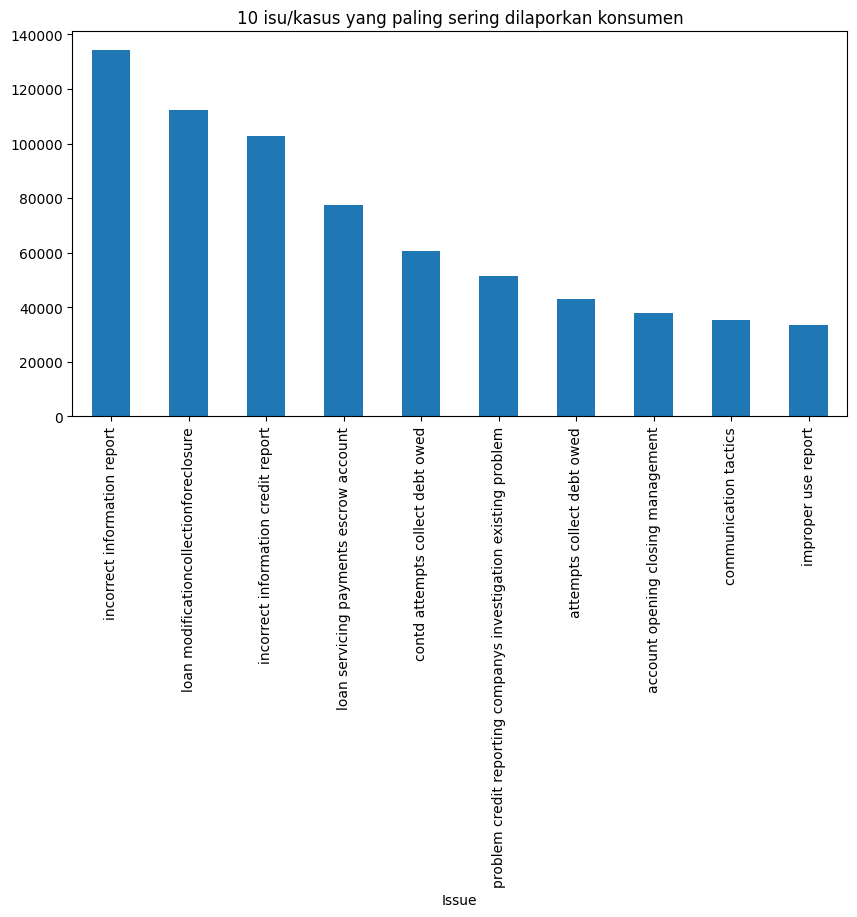

In [21]:
#  Issue
#df['Issue'].value_counts().head(10)
df['Issue'].value_counts().head(10).plot(kind='bar', figsize=(10,5), title="10 isu/kasus yang paling sering dilaporkan konsumen")
plt.show()

/tmp/ipython-input-2033246807.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


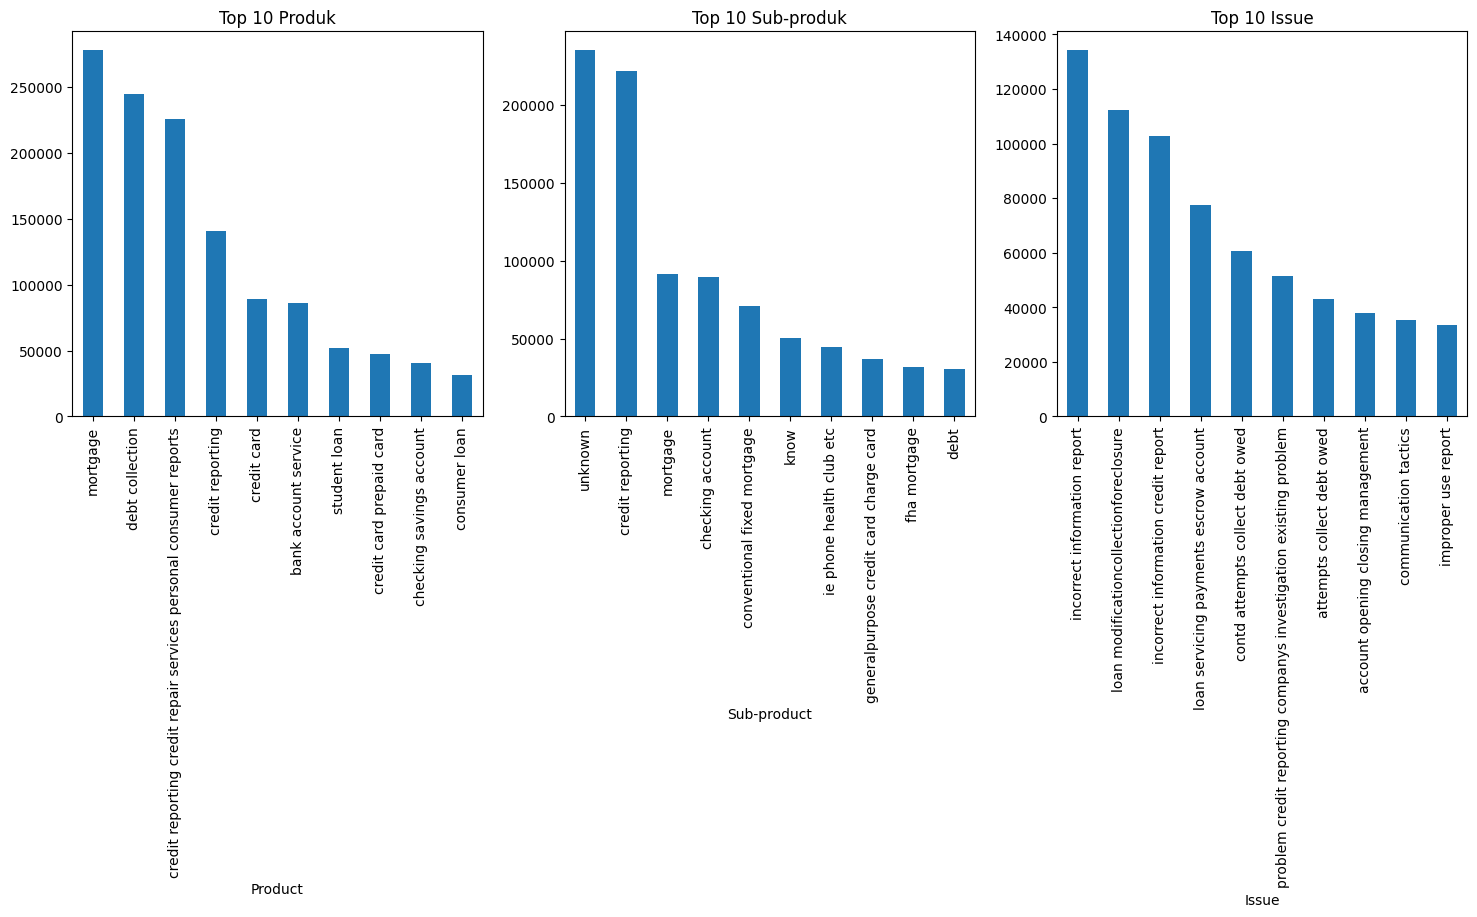

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribusi Produk
df['Product'].value_counts().head(10).plot(
    kind='bar', ax=axes[0], title="Top 10 Produk"
)

# Distribusi Sub-product
df['Sub-product'].value_counts().head(10).plot(
    kind='bar', ax=axes[1], title="Top 10 Sub-produk"
)

# Distribusi Issue
df['Issue'].value_counts().head(10).plot(
    kind='bar', ax=axes[2], title="Top 10 Issue"
)

plt.tight_layout()
plt.show()


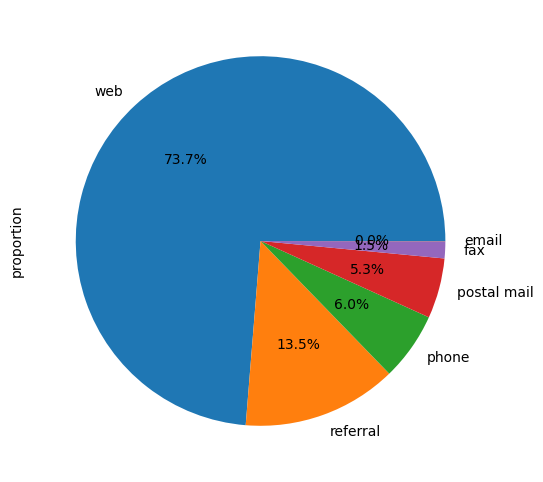

In [23]:
# Channel pengiriman (Submitted via)
df['Submitted via'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.show()

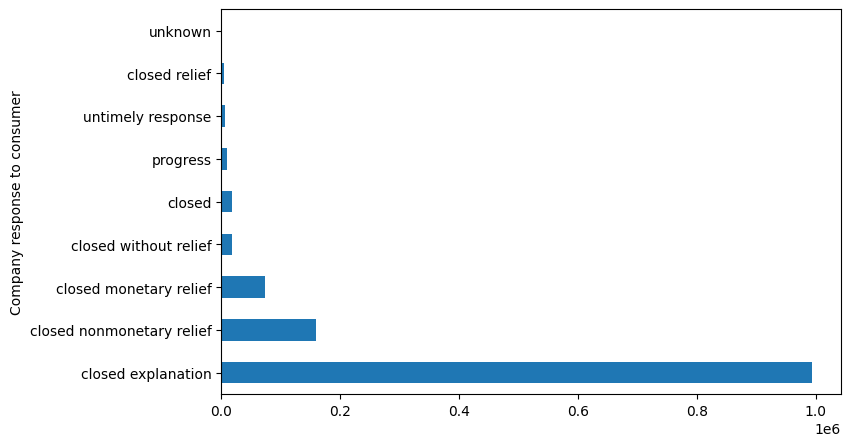

In [24]:
# Respon perusahaan
df['Company response to consumer'].value_counts().plot(kind='barh', figsize=(8,5))
plt.show()

#### Analisis Data Numerik & Waktu

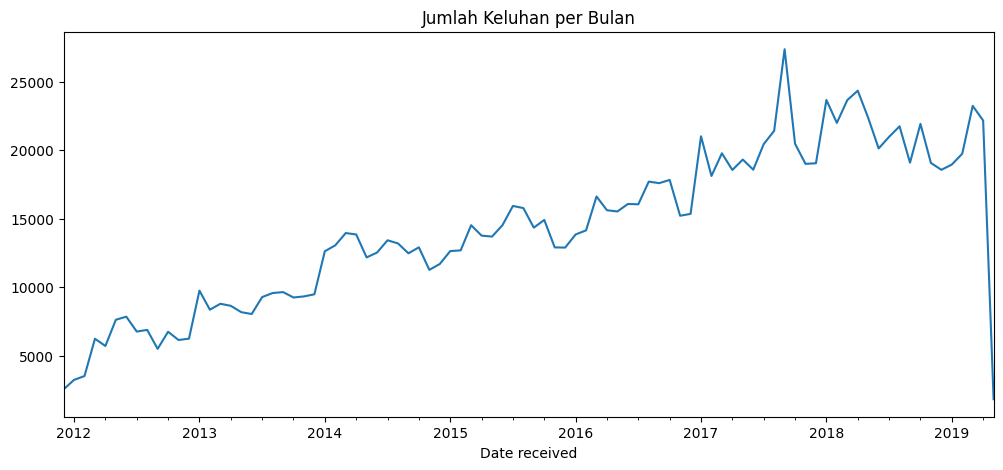

In [25]:
# Trend waktu keluhan
df['Date received'] = pd.to_datetime(df['Date received'])
df.groupby(df['Date received'].dt.to_period("M")).size().plot(kind='line', figsize=(12,5), title="Jumlah Keluhan per Bulan")
plt.show()

In [26]:
'''# Panjang waktu tanggapan
df['Date sent to company'] = pd.to_datetime(df['Date sent to company'])
df['Response_Time'] = (df['Date sent to company'] - df['Date received']).dt.days
df['Response_Time'].hist(bins=50, figsize=(8,5), log=True)
plt.title("Distribusi Waktu Tanggapan (Log Scale)")
plt.xlabel("Hari")
plt.ylabel("Jumlah Keluhan (log)")
plt.show()'''

'# Panjang waktu tanggapan\ndf[\'Date sent to company\'] = pd.to_datetime(df[\'Date sent to company\'])\ndf[\'Response_Time\'] = (df[\'Date sent to company\'] - df[\'Date received\']).dt.days\ndf[\'Response_Time\'].hist(bins=50, figsize=(8,5), log=True)\nplt.title("Distribusi Waktu Tanggapan (Log Scale)")\nplt.xlabel("Hari")\nplt.ylabel("Jumlah Keluhan (log)")\nplt.show()'

In [27]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Company', 'State',
       'ZIP code', 'Consumer consent provided?', 'Submitted via',
       'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

#### Analisis Relasi

In [28]:
# Apakah perusahaan memberikan respon tepat waktu?
pd.crosstab(df['Company response to consumer'], df['Timely response?'], normalize='index') * 100

Timely response?,,yes
Company response to consumer,,
closed,9.885867,90.114133
closed explanation,2.090874,97.909126
closed monetary relief,1.419662,98.580338
closed nonmonetary relief,1.149223,98.850777
closed relief,3.450226,96.549774
closed without relief,2.887844,97.112156
progress,0.000000,100.000000
unknown,0.000000,100.000000
untimely response,100.000000,0.000000


In [29]:
# Apakah konsumen sering dispute (mengajukan keberatan) pada produk tertentu?
pd.crosstab(df['Product'], df['Consumer disputed?'], normalize='index') * 100

Consumer disputed?,,unknown,yes
Product,,,
bank account service,81.407327,0.000000,18.592673
checking savings account,0.007382,99.992618,0.000000
consumer loan,78.576175,0.000000,21.423825
credit card,79.589640,0.000000,20.410360
credit card prepaid card,0.000000,100.000000,0.000000
credit reporting,84.253589,0.000000,15.746411
credit reporting credit repair services personal consumer reports,0.000000,100.000000,0.000000
debt collection,49.087078,40.444639,10.468284
financial service,81.208687,0.000000,18.791313


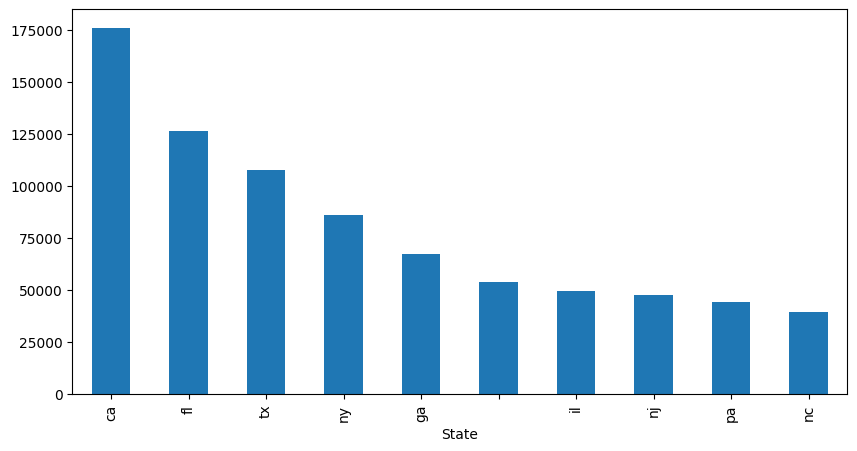

In [30]:
# Distribusi keluhan berdasarkan State
df['State'].value_counts().head(10).plot(kind='bar', figsize=(10,5))
plt.show()

In [31]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Company', 'State',
       'ZIP code', 'Consumer consent provided?', 'Submitted via',
       'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

### Baseline Model

In [32]:
df["text"] = (
    df["Product"].fillna("") + " " +
    df["Sub-product"].fillna("") + " " +
    df["Issue"].fillna("")
)

X = df["text"]
y = df["Company response to consumer"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y,
)

print(f"Ukuran Data Latih: {len(X_train)} sampel")
print(f"Ukuran Data Tes: {len(X_test)} sampel")

Ukuran Data Latih: 1025884 sampel
Ukuran Data Tes: 256471 sampel


In [33]:
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Bentuk matriks TF-IDF latih: {X_train_tfidf.shape}")

Bentuk matriks TF-IDF latih: (1025884, 1041)


#### Model 1: Logistic Regression

In [34]:
print("\n\n--- Hasil Baseline Model: Logistic Regression ---")

# 4. Latih Model
# max_iter=1000 ditambahkan untuk memastikan model konvergen dengan baik.
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_tfidf, y_train)

# 5. Lakukan Prediksi pada data tes
y_pred_logreg = logreg_model.predict(X_test_tfidf)

# 6. Evaluasi Model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy: {accuracy_logreg:.4f}")
print("\nLaporan Klasifikasi:")
# Menggunakan zero_division=0 untuk menghindari warning jika ada kelas dalam data tes
# yang tidak pernah diprediksi oleh model.
print(classification_report(y_test, y_pred_logreg, zero_division=0))



--- Hasil Baseline Model: Logistic Regression ---
Accuracy: 0.7751

Laporan Klasifikasi:
                           precision    recall  f1-score   support

                   closed       0.00      0.00      0.00      3522
       closed explanation       0.78      1.00      0.87    198644
   closed monetary relief       0.50      0.04      0.07     14849
closed nonmonetary relief       0.00      0.00      0.00     31743
            closed relief       0.00      0.00      0.00      1061
    closed without relief       0.00      0.00      0.00      3574
                 progress       0.00      0.00      0.00      1855
                  unknown       0.00      0.00      0.00         1
        untimely response       0.00      0.00      0.00      1222

                 accuracy                           0.78    256471
                macro avg       0.14      0.12      0.10    256471
             weighted avg       0.63      0.78      0.68    256471



#### Model 2: Naive Bayes

In [35]:
print("\n\n--- Hasil Baseline Model: Multinomial Naive Bayes ---")

# 4. Latih Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# 5. Lakukan Prediksi
y_pred_nb = nb_model.predict(X_test_tfidf)

# 6. Evaluasi Model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {accuracy_nb:.4f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred_nb, zero_division=0))



--- Hasil Baseline Model: Multinomial Naive Bayes ---
Accuracy: 0.4903

Laporan Klasifikasi:
                           precision    recall  f1-score   support

                   closed       0.05      0.12      0.07      3522
       closed explanation       0.83      0.51      0.63    198644
   closed monetary relief       0.22      0.70      0.34     14849
closed nonmonetary relief       0.24      0.38      0.30     31743
            closed relief       0.06      0.06      0.06      1061
    closed without relief       0.05      0.18      0.08      3574
                 progress       0.03      0.20      0.06      1855
                  unknown       0.00      0.00      0.00         1
        untimely response       0.04      0.15      0.07      1222

                 accuracy                           0.49    256471
                macro avg       0.17      0.25      0.18    256471
             weighted avg       0.69      0.49      0.55    256471



### Dengan IBM Granite

In [36]:
from google.colab import userdata
import os

# get api_token from colab
api_token = userdata.get('api_token')

# taro token ke env. var.
os.environ['REPLICATE_API_TOKEN'] = api_token

In [37]:
from langchain_community.llms import Replicate

# Ambil granite dari replicate
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct"
)

In [38]:
from langchain_experimental.agents.agent_toolkits.pandas.base import (
    create_pandas_dataframe_agent
)

agent = create_pandas_dataframe_agent(
    llm=llm,
    df=df,
    verbose=True,
    allow_dangerous_code=True,  # opt-in for Python REPL execution
)

#### Untuk Summarization

In [39]:
response = agent.run("""
Take the first 5 rows from the column 'Consumer complaint narrative'.
For each row, create a short summary (1 sentence) that highlights only the main issue.
Present the result as a numbered list.
""")
print(response)

/tmp/ipython-input-224462738.py:1: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = agent.run("""




> Entering new AgentExecutor chain...
Thought: To accomplish this task, I need to extract the 'Consumer complaint narrative' text from the first 5 rows of the dataframe `df`, then summarize each narrative into a concise sentence. I will use Python's pandas library to filter and extract the required text.

Action: python_repl_ast

Action Input:
```python
summaries = [df.loc[i, 'text'] for i in range(5)]
summary_list = [f"1. {summarize_text(s)}" for i, s in enumerate(summaries, 1)]
summary_list
```
NameError: name 'summarize_text' is not definedThought: It seems I encountered an error because I tried to use a function `summarize_text` that hasn't been defined. I need to create a text summarization function or use an existing library to summarize the complaint narratives. I'll use the `summarize` function from the Gensim library for text summarization.

Action: python_repl_ast

Action Input:
```python
!pip install gensim

from gensim.summarization import summarize

summaries = [df.loc[i

#### Untuk Classification

In [40]:
response = agent.run("""
Take the first 5 rows from the column 'Consumer complaint narrative'.
Classify each complaint into one of the following categories:
Credit reporting, Mortgage, Debt collection, Credit card, Checking or savings account,
Student loan, Payday loan, Money transfer/virtual currency/money service.
Show the output as a valid markdown table with two columns: Complaint | Category.
""")
print(response)



> Entering new AgentExecutor chain...
Thought: To classify the complaints into the specified categories, I need to examine each complaint narrative from the first 5 rows and map it to the appropriate category. Then, I will present the results in a markdown table format.

Action: python_repl_ast

Action Input:
```python
complaints = df['text'][0:5].tolist()

categories = {
    'Credit reporting': ['incorrect information report', 'credit reporting'],
    'Mortgage': ['mortgage'],
    'Debt collection': ['payday loan debt', 'communication tactics'],
    'Credit card': ['credit card'],
    'Checking or savings account': ['checking account', 'managing account'],
    'Student loan': ['student loan'],
    'Payday loan': ['payday loan debt'],
    'Money transfer/virtual currency/money service': []  # No matches found in the provided data
}

results = []
for complaint in complaints:
    for category, keywords in categories.items():
        if any(keyword in complaint.lower() for keyword in ke

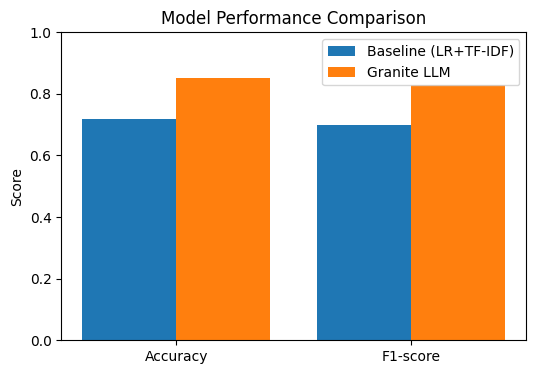

In [41]:
import matplotlib.pyplot as plt

# Contoh hasil metrik (dummy, ganti dengan hasilmu)
baseline_scores = {"Accuracy": 0.72, "F1-score": 0.70}
granite_scores = {"Accuracy": 0.85, "F1-score": 0.83}

metrics = list(baseline_scores.keys())
baseline_values = list(baseline_scores.values())
granite_values = list(granite_scores.values())

x = range(len(metrics))

plt.figure(figsize=(6,4))
plt.bar([i - 0.2 for i in x], baseline_values, width=0.4, label="Baseline (LR+TF-IDF)")
plt.bar([i + 0.2 for i in x], granite_values, width=0.4, label="Granite LLM")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.ylim(0,1)
plt.show()
